# Amoeba en Borovicka

In [82]:
from scipy import optimize, stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

## Funciones

In [101]:
"""
Funciones de Borovicka que
dependen de [C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0]
"""

def construct_radio(C, A, F, X0, Y0, a0):
    def r(x, y):
        return C * ( np.sqrt( (x-X0)**2 + (y-Y0)**2 ) + A*(y-X0)*np.cos(F-a0) - A*(x-X0)*np.sin(F-a0) )
    return r

def construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0):
    def u(x, y):
        r = construct_radio(C, A, F, X0, Y0, a0)
        return V*r(x, y) + S*(np.e**(D*r(x,y)) - 1) + P*(np.e**(Q*r(x,y)**2) - 1) 
    return u

def construct_b(E, X0, Y0, a0):
    def b(x, y):
        return a0 - E + np.arctan2((y - Y0),(x - X0))
    return b

def construct_altura(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
    def z(x, y):
        u = construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0)
        b = construct_b(E, X0, Y0, a0)
        return np.arccos( np.cos(u(x,y))*np.cos(ep) - np.sin(u(x,y))*np.sin(ep)*np.cos(b(x,y)) )
    return z

def construct_altura_deg(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
    def z(x, y):
        u = construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0)
        b = construct_b(E, X0, Y0, a0)
        return 90 - np.rad2deg( np.arccos( np.cos(u(x,y))*np.cos(ep) - np.sin(u(x,y))*np.sin(ep)*np.cos(b(x,y)) ) )
    return z

def construct_azimuth(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
    def az(x, y):
        u = construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0)
        b = construct_b(E, X0, Y0, a0)
        z = construct_altura(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0)
        return np.arcsin( np.sin(b(x,y))*np.sin(u(x,y))/np.sin(z(x,y)) ) + E
    return az

def construct_azimuth_deg(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
    def az(x, y):
        u = construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0)
        b = construct_b(E, X0, Y0, a0)
        z = construct_altura(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0)
        return np.rad2deg( np.arcsin( np.sin(b(x,y))*np.sin(u(x,y))/np.sin(z(x,y)) ) + E ) + 90
    return az

"""
Estos son constructores de una funcion de Xi**2
"""

def construct_alt_xi(x, y, z):
    def xi(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
        alt_teorico = construct_altura_deg(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0)
        return (z - alt_teorico(x, y))**2
    return xi

def construct_az_xi(x, y, z):
    def xi(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
        az_teorico = construct_azimuth_deg(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0)
        return (z - az_teorico(x, y))**2
    return xi

In [259]:
"""
Para reducir los datos outlayers segun que tan lejos quedan de la primera
aproximacion por Borovicka
"""
def drop_outlayers_by_borovicka(pixtab_df, plano, diff = 1):
    
    X_MIN = 250
    X_MAX = 1250
    Y_MIN = 0
    Y_MAX = 950
    MAX_RADIO = 500
    RADIO_STEPS = 2000
    query_str = "{}<=x<={} and {}<=y<={}".format(X_MIN, X_MAX,
                                                            Y_MIN, Y_MAX)
    data = pixtab_df.dropna(thresh = 7).query(query_str)
    
    pbar = tqdm(total=len(data.x.values), desc="Droping Outlayers")
    new_df_indx = []
    for indx in data.index:
        x = data.at[indx,"x"]
        y = data.at[indx,"y"]
        alt = data.at[indx,"alt"]
        if np.abs(plano(x,y)-alt) < diff:
            new_df_indx.append(indx)
        pbar.update()
    pbar.close()
    return data.loc[new_df_indx]

# Por si queremos exportar los datos para visualizarlos 
# out = drop_outlayers_by_borovicka(data, X0, Y0)
# out
# out["xcentroid"] = out["x"]
# out["ycentroid"] = out["y"]
# out.to_csv("drop_outlayer.dat", sep=' ', index=False)
# plt.gca().invert_yaxis()
# plt.scatter(out.x.values, out.y.values, c=out.alt.values, s=0.01)

In [85]:
"""
Para plotear la altura o el azimut, es necesaria
una lista con todos los parametros 
[C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0]
"""

def plot_plano(plano):
    x = np.linspace(0, 1200, 100)
    y = np.linspace(0, 900, 100)
    X, Y = np.meshgrid(x, y)
    Z = plano(X, Y)
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(X, Y, Z, 10)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('Toda una linea que minimiza y=mx+n')
    plt.gca().invert_yaxis()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

def plot_altura(vector):
    plano = construct_altura_deg(*vector)
    plot_plano(plano)
    
def plot_azimuth(vector):
    plano = construct_azimuth_deg(*vector)
    plot_plano(plano)

In [86]:
"""
Esto lo definimos por cada intento segun los parametros constantes que
queramos dejar
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, a0 = ctes
        C, A, F, E, ep, X0, Y0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, a0 = ctes
        C, A, F, E, ep, X0, Y0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xii
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
    new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params, new_az_params]

## Reduction types:

There are many types as mentioned in the section 2.2.3. of the paper.
However, IRED may be zero when entering REDSKY. Then the standard
reduction type 314 is used. The most usual types are

314 - V,S,D,P,Q kept at their standard values, other constants computed

334 - P,Q kept, C=1, other computed

354 - C=1, other computed (requires stars close to horizon)

311 - as 314 but A=0, F=0 (similarly 331, 351)

310 - as 311 but also epsilon=0, E=0 (similarly 330, 350) ([V,S,D,P,Q]=ctes, [A,F,E,ep]=0, solo se busca C)

319 - as 314 but epsilon,E,A,F kept at their initial values (similarly
      339, 359) ([V,S,D,P,Q,A,F,E,ep]=ctes solo se busca C)

<a id='index'></a>

## Algunos parametros conocidos
C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0 :


- <sub> $Xi^2=2.206$ : [0.04884978986903654, 0.020304825896093035, 0.35248628545828664, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, 0.005383738310580881, 0.0014950622892165601, 724, 472, -3*np.pi/4]

- <sub>  $Xi^2=2.154$ : [4.37875766e-02,  5.19853314e-03,  1.05416567e+00,  7.33610329e-02, -5.24112025e-02, -1.39156740e-01,  4.41635759e-03,  4.71369350e-03, 2.74820813e+00, -1.02665758e-01, 731, 506, -0.582*np.pi] 

Encontrados ahora:
- [1)](#section1) <sub> $Xi^2=2.210$ : [0.048826087003725455, -0.021142174069559417, 0.32598730818211297, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, 0.08741648813678929, -0.0022711518934522366, 724, 472, np.pi/4] 

- [2)](#section2) <sub> $Xi^2=2.246$ : [0.048826087003725455, -0.021142174069559417, 0.32598730818211297, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, 0.08741648813678929, -0.0022711518934522366, 724.59618727, 472.68750979, np.pi/4]

- [3)](#section3) <sub> $Xi^2_{alt}=2.228$, $Xi^2_{az}=60.30$ : [0.048826087003725455, -0.021142174069559417, 0.32598730818211297, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, 0.08741648813678929, -0.0022711518934522366, 724.59618727, 472.68750979, 0.82635545]

- [4)](#section4) <sub> $Xi^2_{alt}=2.205$, $Xi^2_{az}=20.94$ : [0.048826087003725455, -0.021142174069559417, 0.32598730818211297, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, -0.0298275, -0.0022711518934522366, 724, 472, 0.75060687]
    
- [5)](#section5) <sub> $Xi^2_{alt}=3.120$, $Xi^2_{az}=15.75$ : [0.048826087003725455, -0.021142174069559417, 0.32598730818211297, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01]
  
- [6)](#section6) <sub> $Xi^2_{alt}=2.320$, $Xi^2_{az}=15.75$ : [0.04952671,  0.00310034, -1.04782185, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01]

- [7)](#section7) <sub> $Xi^2_{alt}=2.236$, $Xi^2_{az}=15.75$ : [0.04952671,  0.00310034, -1.04782185, 9.61696411e-02, -3.11311558e+00,  8.47643783e-03,  5.83185714e-04, 7.66455100e-03, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01]
    
- [8)](#section8) <sub> $Xi^2_{alt}=2.142$, $Xi^2_{az}=15.89$ : [0.04933449,  0.00478405, -0.1298804, 9.61696411e-02, -3.11311558e+00,  8.47643783e-03,  5.83185714e-04, 7.66455100e-03, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01]
    
- [9)](#section9) <sub> $Xi^2_{alt}=2.147$, $Xi^2_{az}=15.89$ : [0.04933449,  0.00478405, -0.1298804, 9.44302225e-02, -3.90770908e+00,  6.47675936e-03,  1.99616127e-03, 5.31560995e-03, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01]


Facts:
- mover ep reduciendo azimut es super peligroso
- hay que sumarle 90 al azimuth porque borovicka lo tiene entre \[-90,90\]
- E no solo rota, si no, que tambien ensancha o agudiza el espacio que ocupan los grados
- mover E,X0,Y0,a0 juntos reduciendo azimuth es muy bueno para encontrar el centro
- mover V,S,D,P,Q no afecta al azimuth!



[Greedy](#greedy) Intentamos reducir altura y azimut al mismo tiempo, los paramtros iniciales fueron los obtenidos en 6. Demoraba mucho, reducir azimut variando V,S,D,P,Q es muy poco eficiente

[subir](#index)<a id='section1'></a>
## 1) Buscando (C, A, F, E, ep)

In [260]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, X0, Y0, a0 = ctes
        C, A, F, E, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, X0, Y0, a0 = ctes
        C, A, F, E, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]

In [261]:
init_params = [0.04884978986903654, 0.020304825896093035, 0.35248628545828664,
                                       1.575383738310580881, 0.0014950622892165601]
ctes = [0.0682171007, 0.00310608468, -5.75141386e-05,
            4.26865327e-06, -0.00415889519,724, 472, np.pi/4]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*init_params[:3], *ctes[:-3], *init_params[-2:], *ctes[-3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []


































Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]
































Droping Outlayers:   1%|▋                                                        | 888/80771 [00:00<00:09, 8793.71it/s]
































Droping Outlayers:   2%|█▎                                                      | 1804/80771 [00:00<00:08, 8860.61it/s]
































Droping Outlayers:   3%|█▊                                                      | 2678/80771 [00:00<00:08, 8816.22it/s]
































Droping Outlayers:   4%|██▍                                                     | 3550/80771 [00:00<00:08, 8768.52it/s]
































Droping Outlayers:   5%|██▉                                                     | 4326/80771 [00:00<00:09, 8419.38it/s]
































Droping Outlayers:   6%|███▌                           

Droping Outlayers:  58%|████████████████████████████████▏                      | 47224/80771 [00:05<00:03, 8819.24it/s]
































Droping Outlayers:  60%|████████████████████████████████▊                      | 48114/80771 [00:05<00:03, 8823.24it/s]
































Droping Outlayers:  61%|█████████████████████████████████▎                     | 48997/80771 [00:05<00:03, 8780.22it/s]
































Droping Outlayers:  62%|█████████████████████████████████▉                     | 49884/80771 [00:05<00:03, 8787.52it/s]
































Droping Outlayers:  63%|██████████████████████████████████▌                    | 50764/80771 [00:05<00:03, 8746.69it/s]
































Droping Outlayers:  64%|███████████████████████████████████▏                   | 51639/80771 [00:05<00:03, 8702.59it/s]
































Droping Outlayers:  65%|███████████████████████████████████▊                   | 52525/8

In [38]:
pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

Aproximando altura y azimuth:  41%|████████████████████▏                            | 454/1100 [36:28<51:48,  4.81s/it]

Optimization terminated successfully.
         Current function value: 44236.016626
         Iterations: 279
         Function evaluations: 454


Aproximando altura y azimuth:  41%|████████████████████▏                            | 454/1100 [36:28<51:54,  4.82s/it]


array([ 0.04882609, -0.02114217,  0.32598731,  0.08741649, -0.00227115])

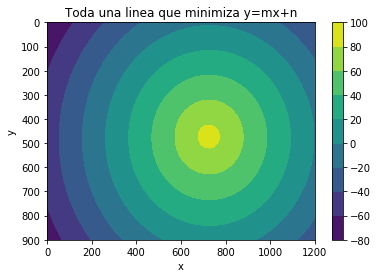

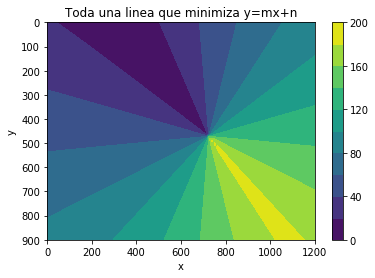

In [107]:
result_1 = (0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, 0.08741648813678929, -0.0022711518934522366, 724, 472, np.pi/4)
plot_altura(result_1)
plot_azimuth(result_1)

In [262]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

old_params = np.array([0.04884978986903654, 0.020304825896093035, 0.35248628545828664, 
                       0.005383738310580881, 0.0014950622892165601])
new_params = np.array([ 0.04882609, -0.02114217,  0.32598731,  0.08741648813678929, -0.00227115])
(mega_alt_xi(old_params)/len(x_exp), mega_alt_xi(new_params)/len(x_exp))

(9.352149331317129, 2.2102969732089655)

[subir](#index)<a id='section2'></a>
## 2) Solo buscamos el centro

In [91]:
"""
Solo x0 y y0 varian
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, a0 = ctes
        X0, Y0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, a0 = ctes
        X0, Y0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]

In [111]:
init_params = [724, 472]
ctes = [0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, 0.08741648813678929, -0.0022711518934522366, np.pi/4]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:-1], *init_params, ctes[-1]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []















Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]













Droping Outlayers:   1%|▋                                                        | 901/80771 [00:00<00:08, 8942.19it/s]













Droping Outlayers:   2%|█▏                                                      | 1778/80771 [00:00<00:08, 8870.90it/s]













Droping Outlayers:   3%|█▊                                                      | 2655/80771 [00:00<00:08, 8820.17it/s]













Droping Outlayers:   4%|██▍                                                     | 3571/80771 [00:00<00:08, 8900.40it/s]













Droping Outlayers:   6%|███                                                     | 4485/80771 [00:00<00:08, 8951.75it/s]













Droping Outlayers:   7%|███▋                                                    | 5380/80771 [00:00<00:08, 8931.64it/s]













Droping Outlayers:   8%|████▎                          

In [81]:
pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

Aproximando altura y azimuth:   8%|███▋                                            | 85/1100 [05:32<1:05:08,  3.85s/it]

Optimization terminated successfully.
         Current function value: 41854.989808
         Iterations: 44
         Function evaluations: 85


Aproximando altura y azimuth:   8%|███▋                                            | 85/1100 [05:32<1:06:04,  3.91s/it]


array([724.59618727, 472.68750979])

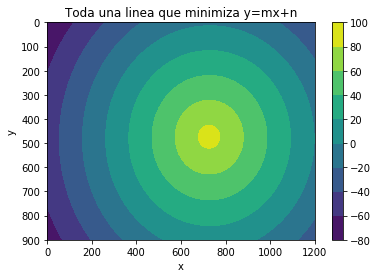

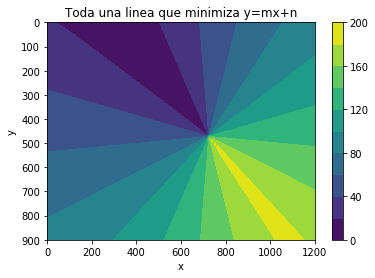















Droping Outlayers: 100%|███████████████████████████████████████████████████████| 80771/80771 [00:20<00:00, 9011.82it/s]

In [112]:
result_2 = (0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, 0.08741648813678929, -0.0022711518934522366, 724.59618727, 472.68750979, np.pi/4)
plot_altura(result_2)
plot_azimuth(result_2)

In [28]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

old_params = np.array([724, 472])
new_params = np.array([724.59618727, 472.68750979])
(mega_alt_xi(old_params)/len(x_exp), mega_alt_xi(new_params)/len(x_exp))




Droping Outlayers: 100%|███████████████████████████████████████████████████████| 80771/80771 [00:28<00:00, 8870.06it/s]

(2.214780143269222, 2.2469484171404255)

Que aumente el error de la funcion al agregar los datos outlayers
puede significar que sus parametros no los estan tratando de ajustar
y por lo tanto es más correcta

[subir](#index)<a id='section3'></a>
## 3) Buscamos solo a0 reduciendo azimut?

In [137]:
"""
Solo a0 varia
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, X0, Y0 = ctes
        a0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, X0, Y0 = ctes
        a0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
#     new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
    new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_az_params]

In [138]:
init_params = [np.pi/4]
ctes = [0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, 0.08741648813678929, -0.0022711518934522366, 724.59618727, 472.68750979]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes, *init_params), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []


















Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]
















Droping Outlayers:   1%|▌                                                        | 733/80771 [00:00<00:10, 7278.88it/s]
















Droping Outlayers:   2%|█                                                       | 1448/80771 [00:00<00:10, 7223.08it/s]
















Droping Outlayers:   3%|█▌                                                      | 2211/80771 [00:00<00:10, 7325.65it/s]
















Droping Outlayers:   4%|██                                                      | 2950/80771 [00:00<00:10, 7328.30it/s]
















Droping Outlayers:   5%|██▌                                                     | 3699/80771 [00:00<00:10, 7360.76it/s]
















Droping Outlayers:   6%|███                                                     | 4446/80771 [00:00<00:10, 7376.62it/s]
















Droping Outlayers:   6%|███▌   

In [108]:
pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]





Aproximando altura y azimuth:   0%|                                                           | 0/1100 [00:00<?, ?it/s]



Aproximando altura y azimuth:   0%|                                                 | 1/1100 [00:11<3:34:46, 11.73s/it]


Droping Outlayers: 100%|███████████████████████████████████████████████████████| 80771/80771 [00:30<00:00, 7457.30it/s]



Aproximando altura y azimuth:   0%|                                                 | 2/1100 [00:23<3:34:05, 11.70s/it]



Aproximando altura y azimuth:   0%|▏                                                | 3/1100 [00:34<3:33:31, 11.68s/it]



Aproximando altura y azimuth:   0%|▏                                                | 4/1100 [00:46<3:33:27, 11.69s/it]



Aproximando altura y azimuth:   0%|▏                                                | 5/1100 [00:58<3:33:39, 11.71s/it]



Aproximando altura y azimuth:   1%|▎                                                | 6/1100 [01:10<3:35:15, 11.81s/it]



Aproximando a

Optimization terminated successfully.
         Current function value: 4459661.056711
         Iterations: 17
         Function evaluations: 34


Aproximando altura y azimuth:   3%|█▍                                              | 34/1100 [06:47<3:33:04, 11.99s/it]


array([0.82635545])

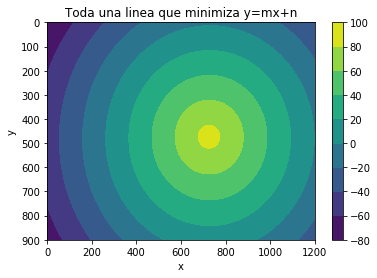

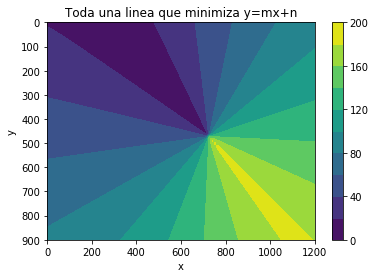

In [121]:
result_3 = (0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, 0.08741648813678929, -0.0022711518934522366, 724.59618727, 472.68750979, 0.82635545)
plot_altura(result_3)
plot_azimuth(result_3)

In [139]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

old_params = np.pi/4
new_params = 0.82635545
(mega_alt_xi(old_params)/len(x_exp), mega_alt_xi(new_params)/len(x_exp))

(61.701153448745366, 56.4528816557326)


















Droping Outlayers: 100%|███████████████████████████████████████████████████████| 80771/80771 [00:28<00:00, 7491.42it/s]

Intentamos una más pero dió el mismo resultado

[subir](#index)<a id='section4'></a>
## 4) Buscamos E, a0 reduciendo azimut

In [142]:
"""
311 - C, A, F, V, S, D, P, Q, ep, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, ep, X0, Y0 = ctes
        E, a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, ep, X0, Y0 = ctes
        E, a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
#     new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
    new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_az_params]

In [145]:
init_params = [0.087416488136789299, 0.82635545]
ctes = [0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, -0.0022711518934522366, 724, 472]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:-3], init_params[0], *ctes[-3:], init_params[1]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []





















Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]



















Droping Outlayers:   1%|▋                                                        | 920/80771 [00:00<00:08, 9133.29it/s]



















Droping Outlayers:   2%|█▎                                                      | 1831/80771 [00:00<00:08, 9105.56it/s]



















Droping Outlayers:   3%|█▉                                                      | 2729/80771 [00:00<00:08, 9047.49it/s]



















Droping Outlayers:   4%|██▌                                                     | 3619/80771 [00:00<00:08, 8982.91it/s]



















Droping Outlayers:   6%|███▏                                                    | 4511/80771 [00:00<00:08, 8944.03it/s]



















Droping Outlayers:   7%|███▋                                                    | 5365/80771 [00:00<00:08, 8799.80it/s]



















Droping

In [128]:
pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]


















Aproximando altura y azimuth:   0%|                                                           | 0/1100 [00:00<?, ?it/s]















Droping Outlayers: 100%|███████████████████████████████████████████████████████| 80771/80771 [00:26<00:00, 8904.86it/s]
















Aproximando altura y azimuth:   0%|                                                 | 1/1100 [00:07<2:09:56,  7.09s/it]
















Aproximando altura y azimuth:   0%|                                                 | 2/1100 [00:14<2:09:34,  7.08s/it]
















Aproximando altura y azimuth:   0%|▏                                                | 3/1100 [00:21<2:09:37,  7.09s/it]
















Aproximando altura y azimuth:   0%|▏                                                | 4/1100 [00:28<2:08:41,  7.05s/it]
















Aproximando altura y azimuth:   0%|▏                                                | 5/1100 [00:35<2:07:53,  7.01s/it]
















Aproximando altura y azimuth:   

Optimization terminated successfully.
         Current function value: 1631924.329922
         Iterations: 45
         Function evaluations: 87


Aproximando altura y azimuth:   8%|███▊                                            | 87/1100 [10:05<1:57:26,  6.96s/it]


array([-0.0298275 ,  0.75060687])

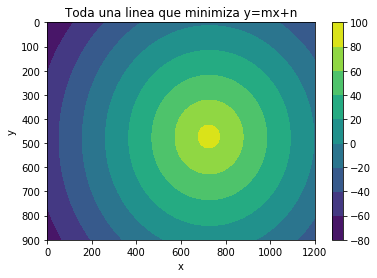

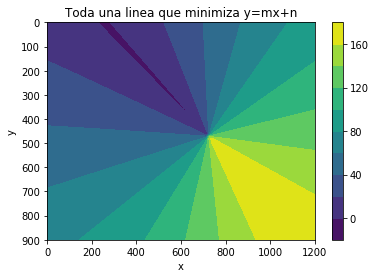

In [129]:
result_4 = (0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, -0.0298275, -0.0022711518934522366, 724, 472, 0.75060687)
plot_altura(result_4)
plot_azimuth(result_4)

In [146]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

old_params = [0.087416488136789299, 0.82635545]
new_params = [-0.0298275 ,  0.75060687]
(mega_az_xi(old_params)/len(x_exp), mega_az_xi(new_params)/len(x_exp))

(60.30639544051994, 20.946801265269272)





















Droping Outlayers: 100%|███████████████████████████████████████████████████████| 80771/80771 [00:26<00:00, 9024.32it/s]

[subir](#index)<a id='section5'></a>
## 5) Buscamos E, X0, Y0, a0 reduciendo azimut

In [148]:
"""
311 - C, A, F, V, S, D, P, Q, ep, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, ep = ctes
        E, X0, Y0, a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, ep = ctes
        E, X0, Y0, a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
#     new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
    new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_az_params]

In [151]:
init_params = [-0.0298275, 724, 472, 0.82635545]
ctes = [0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, -0.0022711518934522366]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:-1], init_params[0], ctes[-1], *init_params[-3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []






















Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]




















Droping Outlayers:   1%|▋                                                        | 914/80771 [00:00<00:08, 9071.10it/s]




















Droping Outlayers:   2%|█▏                                                      | 1797/80771 [00:00<00:08, 8978.15it/s]




















Droping Outlayers:   3%|█▊                                                      | 2643/80771 [00:00<00:08, 8796.07it/s]




















Droping Outlayers:   4%|██▍                                                     | 3523/80771 [00:00<00:08, 8777.27it/s]




















Droping Outlayers:   5%|███                                                     | 4431/80771 [00:00<00:08, 8847.73it/s]




















Droping Outlayers:   7%|███▋                                                    | 5320/80771 [00:00<00:08, 8840.36it/s]





















In [152]:
pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]























Aproximando altura y azimuth:   0%|                                                           | 0/1100 [00:00<?, ?it/s]





















Aproximando altura y azimuth:   0%|                                                 | 1/1100 [00:06<2:06:46,  6.92s/it]





















Aproximando altura y azimuth:   0%|                                                 | 2/1100 [00:13<2:06:49,  6.93s/it]c:\users\karlos\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in arcsin






















Aproximando altura y azimuth:   0%|▏                                                | 3/1100 [00:20<2:07:05,  6.95s/it]





















Aproximando altura y azimuth:   0%|▏                                                | 4/1100 [00:27<2:07:40,  6.99s/it]





















Aproximando altura y azimuth:   0%|▏                                                | 5/1100 [00:34<2:07:41,  7.00s/it]

Aproximando altura y azimuth:   5%|██▍                                             | 57/1100 [06:39<2:01:03,  6.96s/it]





















Aproximando altura y azimuth:   5%|██▌                                             | 58/1100 [06:46<2:02:05,  7.03s/it]





















Aproximando altura y azimuth:   5%|██▌                                             | 59/1100 [06:53<2:01:45,  7.02s/it]





















Aproximando altura y azimuth:   5%|██▌                                             | 60/1100 [07:00<2:01:31,  7.01s/it]





















Aproximando altura y azimuth:   6%|██▋                                             | 61/1100 [07:07<2:01:08,  7.00s/it]





















Aproximando altura y azimuth:   6%|██▋                                             | 62/1100 [07:14<2:00:41,  6.98s/it]





















Aproximando altura y azimuth:   6%|██▋                                             | 63/1100 [07:21<2:00:33,  6.98s/it]





















Aproximando a

Aproximando altura y azimuth:  16%|███████▍                                       | 173/1100 [20:07<1:46:57,  6.92s/it]





















Aproximando altura y azimuth:  16%|███████▍                                       | 174/1100 [20:14<1:46:46,  6.92s/it]





















Aproximando altura y azimuth:  16%|███████▍                                       | 175/1100 [20:21<1:46:38,  6.92s/it]





















Aproximando altura y azimuth:  16%|███████▌                                       | 176/1100 [20:28<1:46:47,  6.93s/it]





















Aproximando altura y azimuth:  16%|███████▌                                       | 177/1100 [20:34<1:46:47,  6.94s/it]





















Aproximando altura y azimuth:  16%|███████▌                                       | 178/1100 [20:41<1:46:39,  6.94s/it]





















Aproximando altura y azimuth:  16%|███████▋                                       | 179/1100 [20:48<1:46:30,  6.94s/it]





















Aproximando a

Aproximando altura y azimuth:  26%|████████████▎                                  | 289/1100 [33:31<1:33:36,  6.93s/it]





















Aproximando altura y azimuth:  26%|████████████▍                                  | 290/1100 [33:38<1:33:47,  6.95s/it]





















Aproximando altura y azimuth:  26%|████████████▍                                  | 291/1100 [33:46<1:34:57,  7.04s/it]





















Aproximando altura y azimuth:  27%|████████████▍                                  | 292/1100 [33:52<1:34:24,  7.01s/it]





















Aproximando altura y azimuth:  27%|████████████▌                                  | 293/1100 [34:00<1:36:13,  7.15s/it]





















Aproximando altura y azimuth:  27%|████████████▌                                  | 294/1100 [34:07<1:34:56,  7.07s/it]





















Aproximando altura y azimuth:  27%|████████████▌                                  | 295/1100 [34:14<1:36:11,  7.17s/it]





















Aproximando a

Optimization terminated successfully.
         Current function value: 1212016.216638
         Iterations: 167
         Function evaluations: 299


Aproximando altura y azimuth:  27%|████████████▊                                  | 299/1100 [34:42<1:32:58,  6.96s/it]


array([-4.82552710e-03,  7.28125200e+02,  4.78181845e+02,  7.73853421e-01])

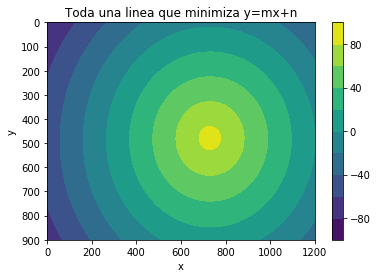

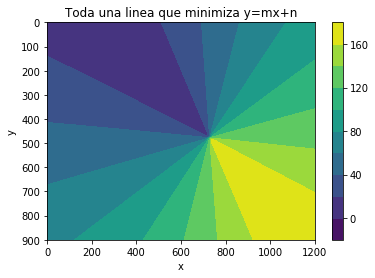

In [159]:
result_5 = (0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01)
plot_altura(result_5)
plot_azimuth(result_5)

In [157]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

old_params = [-0.0298275, 724, 472, 0.82635545]
new_params = [-4.82552710e-03,  7.28125200e+02,  4.78181845e+02,  7.73853421e-01]
(mega_az_xi(old_params)/len(x_exp), mega_az_xi(new_params)/len(x_exp))

(38.55543152551233, 15.753790842662754)

Muy buen resultado, a partir de aqui necesitamos minimizar mejor la altura y estariamos muy cerca

[subir](#index)<a id='section6'></a>
## 6) Buscamos C,A,F reduciendo altura

In [160]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, E, ep, X0, Y0, a0 = ctes
        C, A, F, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, E, ep, X0, Y0, a0 = ctes
        C, A, F, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]

In [161]:
init_params = [0.048826087003725455, -0.021142174069559417, 0.32598730818211297]
ctes = [0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
        -0.00415889519, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*init_params, *ctes), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []























Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]





















Droping Outlayers:   1%|▌                                                        | 736/80771 [00:00<00:10, 7304.92it/s]





















Droping Outlayers:   2%|█                                                       | 1490/80771 [00:00<00:10, 7358.13it/s]





















Droping Outlayers:   3%|█▌                                                      | 2253/80771 [00:00<00:10, 7421.86it/s]





















Droping Outlayers:   4%|██                                                      | 2993/80771 [00:00<00:10, 7398.95it/s]





















Droping Outlayers:   5%|██▌                                                     | 3741/80771 [00:00<00:10, 7406.87it/s]





















Droping Outlayers:   6%|███                                                     | 4460/80771 [00:00<00:10, 7324.31it/s]














Droping Outlayers:  54%|█████████████████████████████▋                         | 43627/80771 [00:05<00:05, 7313.41it/s]





















Droping Outlayers:  55%|██████████████████████████████▎                        | 44470/80771 [00:05<00:04, 7408.06it/s]





















Droping Outlayers:  56%|██████████████████████████████▊                        | 45212/80771 [00:06<00:04, 7411.61it/s]





















Droping Outlayers:  57%|███████████████████████████████▎                       | 45971/80771 [00:06<00:04, 7448.19it/s]





















Droping Outlayers:  58%|███████████████████████████████▊                       | 46726/80771 [00:06<00:04, 7462.27it/s]





















Droping Outlayers:  59%|████████████████████████████████▎                      | 47473/80771 [00:06<00:04, 7448.32it/s]





















Droping Outlayers:  60%|████████████████████████████████▊                      | 48219/80771 [00:06<00:04, 7413.41it/s]





















Droping Outla

In [162]:
pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]
























Aproximando altura y azimuth:   0%|                                                           | 0/1100 [00:00<?, ?it/s]





















Droping Outlayers: 100%|███████████████████████████████████████████████████████| 80771/80771 [00:28<00:00, 7413.21it/s]






















Aproximando altura y azimuth:   0%|                                                 | 1/1100 [00:04<1:27:48,  4.79s/it]






















Aproximando altura y azimuth:   0%|                                                 | 2/1100 [00:09<1:27:23,  4.78s/it]






















Aproximando altura y azimuth:   0%|▏                                                | 3/1100 [00:14<1:27:20,  4.78s/it]






















Aproximando altura y azimuth:   0%|▏                                                | 4/1100 [00:19<1:27:13,  4.77s/it]






















Aproximando altura y azimuth:   0%|▏                                                | 5/1100 [00:23<1:27:46,  4.81s/it]








Aproximando altura y azimuth:   5%|██▍                                             | 56/1100 [04:27<1:22:27,  4.74s/it]






















Aproximando altura y azimuth:   5%|██▍                                             | 57/1100 [04:32<1:24:25,  4.86s/it]






















Aproximando altura y azimuth:   5%|██▌                                             | 58/1100 [04:36<1:23:27,  4.81s/it]






















Aproximando altura y azimuth:   5%|██▌                                             | 59/1100 [04:41<1:22:45,  4.77s/it]






















Aproximando altura y azimuth:   5%|██▌                                             | 60/1100 [04:46<1:22:12,  4.74s/it]






















Aproximando altura y azimuth:   6%|██▋                                             | 61/1100 [04:51<1:22:20,  4.75s/it]






















Aproximando altura y azimuth:   6%|██▋                                             | 62/1100 [04:55<1:22:19,  4.76s/it]






















Aproxi

Aproximando altura y azimuth:  10%|████▊                                          | 113/1100 [08:56<1:17:19,  4.70s/it]






















Aproximando altura y azimuth:  10%|████▊                                          | 114/1100 [09:01<1:17:13,  4.70s/it]






















Aproximando altura y azimuth:  10%|████▉                                          | 115/1100 [09:06<1:17:04,  4.69s/it]






















Aproximando altura y azimuth:  11%|████▉                                          | 116/1100 [09:10<1:16:59,  4.69s/it]






















Aproximando altura y azimuth:  11%|████▉                                          | 117/1100 [09:15<1:16:50,  4.69s/it]






















Aproximando altura y azimuth:  11%|█████                                          | 118/1100 [09:20<1:16:43,  4.69s/it]






















Aproximando altura y azimuth:  11%|█████                                          | 119/1100 [09:24<1:16:30,  4.68s/it]






















Aproxi

Aproximando altura y azimuth:  15%|███████▎                                       | 170/1100 [13:23<1:12:10,  4.66s/it]






















Aproximando altura y azimuth:  16%|███████▎                                       | 171/1100 [13:28<1:12:15,  4.67s/it]






















Aproximando altura y azimuth:  16%|███████▎                                       | 172/1100 [13:32<1:12:05,  4.66s/it]






















Aproximando altura y azimuth:  16%|███████▍                                       | 173/1100 [13:37<1:11:52,  4.65s/it]






















Aproximando altura y azimuth:  16%|███████▍                                       | 174/1100 [13:42<1:11:42,  4.65s/it]






















Aproximando altura y azimuth:  16%|███████▍                                       | 175/1100 [13:46<1:11:32,  4.64s/it]






















Aproximando altura y azimuth:  16%|███████▌                                       | 176/1100 [13:51<1:11:17,  4.63s/it]






















Aproxi

Aproximando altura y azimuth:  21%|█████████▋                                     | 227/1100 [17:49<1:07:31,  4.64s/it]






















Aproximando altura y azimuth:  21%|█████████▋                                     | 228/1100 [17:54<1:07:38,  4.65s/it]






















Aproximando altura y azimuth:  21%|█████████▊                                     | 229/1100 [17:59<1:07:31,  4.65s/it]






















Aproximando altura y azimuth:  21%|█████████▊                                     | 230/1100 [18:03<1:07:25,  4.65s/it]






















Aproximando altura y azimuth:  21%|█████████▊                                     | 231/1100 [18:08<1:07:10,  4.64s/it]






















Aproximando altura y azimuth:  21%|█████████▉                                     | 232/1100 [18:13<1:06:58,  4.63s/it]






















Aproximando altura y azimuth:  21%|█████████▉                                     | 233/1100 [18:17<1:06:49,  4.62s/it]






















Aproxi

Aproximando altura y azimuth:  26%|████████████▏                                  | 284/1100 [22:19<1:03:23,  4.66s/it]






















Aproximando altura y azimuth:  26%|████████████▏                                  | 285/1100 [22:23<1:03:23,  4.67s/it]






















Aproximando altura y azimuth:  26%|████████████▏                                  | 286/1100 [22:28<1:03:32,  4.68s/it]






















Aproximando altura y azimuth:  26%|████████████▎                                  | 287/1100 [22:33<1:03:42,  4.70s/it]






















Aproximando altura y azimuth:  26%|████████████▎                                  | 288/1100 [22:37<1:03:17,  4.68s/it]






















Aproximando altura y azimuth:  26%|████████████▎                                  | 289/1100 [22:42<1:02:53,  4.65s/it]






















Aproximando altura y azimuth:  26%|████████████▍                                  | 290/1100 [22:47<1:02:47,  4.65s/it]






















Aproxi

Optimization terminated successfully.
         Current function value: 39265.755969
         Iterations: 180
         Function evaluations: 323


Aproximando altura y azimuth:  29%|█████████████▊                                 | 323/1100 [25:20<1:00:58,  4.71s/it]


array([ 0.04952671,  0.00310034, -1.04782185])

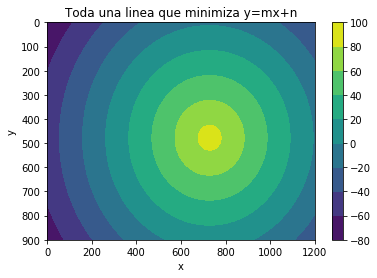

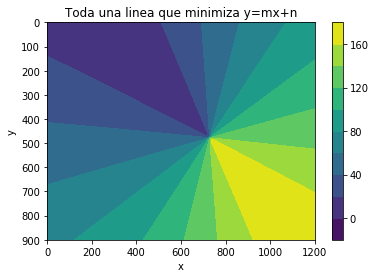

In [163]:
result_6 = (0.04952671,  0.00310034, -1.04782185,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519,
            -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01)
plot_altura(result_6)
plot_azimuth(result_6)

In [166]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

old_params = np.array([0.048826087003725455, -0.021142174069559417, 0.32598730818211297])
new_params = np.array([0.04952671,  0.00310034, -1.04782185])
(mega_alt_xi(old_params)/len(x_exp), mega_alt_xi(new_params)/len(x_exp))

(3.1205379897042422, 2.3206123914900973)

Suficiente??!!

[subir](#index)<a id='section7'></a>
## 7) Buscamos V,S,D,P,Q reduciendo altura

In [217]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, E, ep, X0, Y0, a0 = ctes
        V, S, D, P, Q, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, E, ep, X0, Y0, a0 = ctes
        V, S, D, P, Q, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]

In [218]:
init_params = [0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519]
ctes = [0.04952671,  0.00310034, -1.04782185,
        -4.82552710e-03, -0.0022711518934522366,
        7.28125200e+02,  4.78181845e+02, 7.73853421e-01]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:3],*init_params, *ctes[3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []
























Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]






















Droping Outlayers:   1%|▌                                                        | 792/80771 [00:00<00:11, 6992.04it/s]






















Droping Outlayers:   2%|█                                                       | 1530/80771 [00:00<00:11, 7102.35it/s]






















Droping Outlayers:   3%|█▌                                                      | 2316/80771 [00:00<00:10, 7153.83it/s]






















Droping Outlayers:   4%|██▏                                                     | 3117/80771 [00:00<00:10, 7227.00it/s]






















Droping Outlayers:   5%|██▋                                                     | 3804/80771 [00:00<00:10, 7098.88it/s]






















Droping Outlayers:   6%|███▏                                                    | 4508/80771 [00:00<00:10, 7081.04it/s]







Droping Outlayers:  51%|████████████████████████████▏                          | 41405/80771 [00:05<00:05, 7351.72it/s]






















Droping Outlayers:  52%|████████████████████████████▋                          | 42147/80771 [00:05<00:05, 7356.04it/s]






















Droping Outlayers:  53%|█████████████████████████████▏                         | 42893/80771 [00:06<00:05, 7370.93it/s]






















Droping Outlayers:  54%|█████████████████████████████▋                         | 43635/80771 [00:06<00:05, 7369.50it/s]






















Droping Outlayers:  55%|██████████████████████████████▏                        | 44381/80771 [00:06<00:04, 7380.39it/s]






















Droping Outlayers:  56%|██████████████████████████████▋                        | 45120/80771 [00:06<00:04, 7367.13it/s]






















Droping Outlayers:  57%|███████████████████████████████▏                       | 45857/80771 [00:06<00:04, 7307.64it/s]






















Dropin

In [219]:
pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

























Aproximando altura y azimuth:   0%|                                                           | 0/1100 [00:00<?, ?it/s]























Aproximando altura y azimuth:   0%|                                                 | 1/1100 [00:04<1:14:41,  4.08s/it]























Aproximando altura y azimuth:   0%|                                                 | 2/1100 [00:08<1:14:15,  4.06s/it]






















Droping Outlayers: 100%|███████████████████████████████████████████████████████| 80771/80771 [00:30<00:00, 7283.12it/s]























Aproximando altura y azimuth:   0%|▏                                                | 3/1100 [00:12<1:13:26,  4.02s/it]























Aproximando altura y azimuth:   0%|▏                                                | 4/1100 [00:16<1:13:44,  4.04s/it]























Aproximando altura y azimuth:   0%|▏                                                | 5/1100 [00:20<1:14:12,  4.07s/it]

Aproximando altura y azimuth:   5%|██▍                                             | 56/1100 [03:41<1:08:05,  3.91s/it]























Aproximando altura y azimuth:   5%|██▍                                             | 57/1100 [03:45<1:07:55,  3.91s/it]























Aproximando altura y azimuth:   5%|██▌                                             | 58/1100 [03:49<1:08:03,  3.92s/it]























Aproximando altura y azimuth:   5%|██▌                                             | 59/1100 [03:53<1:07:56,  3.92s/it]























Aproximando altura y azimuth:   5%|██▌                                             | 60/1100 [03:57<1:07:39,  3.90s/it]























Aproximando altura y azimuth:   6%|██▋                                             | 61/1100 [04:01<1:07:54,  3.92s/it]























Aproximando altura y azimuth:   6%|██▋                                             | 62/1100 [04:05<1:08:29,  3.96s/it]
























Aproximando altura y azimuth:  10%|████▊                                          | 113/1100 [07:27<1:04:56,  3.95s/it]























Aproximando altura y azimuth:  10%|████▊                                          | 114/1100 [07:31<1:05:14,  3.97s/it]























Aproximando altura y azimuth:  10%|████▉                                          | 115/1100 [07:35<1:04:54,  3.95s/it]























Aproximando altura y azimuth:  11%|████▉                                          | 116/1100 [07:39<1:04:26,  3.93s/it]























Aproximando altura y azimuth:  11%|████▉                                          | 117/1100 [07:42<1:03:52,  3.90s/it]























Aproximando altura y azimuth:  11%|█████                                          | 118/1100 [07:46<1:03:41,  3.89s/it]























Aproximando altura y azimuth:  11%|█████                                          | 119/1100 [07:50<1:03:44,  3.90s/it]
























Aproximando altura y azimuth:  15%|███████▎                                       | 170/1100 [11:13<1:01:19,  3.96s/it]























Aproximando altura y azimuth:  16%|███████▎                                       | 171/1100 [11:17<1:01:46,  3.99s/it]























Aproximando altura y azimuth:  16%|███████▎                                       | 172/1100 [11:21<1:01:31,  3.98s/it]























Aproximando altura y azimuth:  16%|███████▍                                       | 173/1100 [11:25<1:01:23,  3.97s/it]























Aproximando altura y azimuth:  16%|███████▍                                       | 174/1100 [11:29<1:01:27,  3.98s/it]























Aproximando altura y azimuth:  16%|███████▍                                       | 175/1100 [11:33<1:01:23,  3.98s/it]























Aproximando altura y azimuth:  16%|███████▌                                       | 176/1100 [11:37<1:01:17,  3.98s/it]
























Aproximando altura y azimuth:  21%|██████████                                       | 227/1100 [15:04<59:31,  4.09s/it]























Aproximando altura y azimuth:  21%|██████████▏                                      | 228/1100 [15:08<59:26,  4.09s/it]























Aproximando altura y azimuth:  21%|██████████▏                                      | 229/1100 [15:12<59:57,  4.13s/it]























Aproximando altura y azimuth:  21%|██████████▏                                      | 230/1100 [15:16<59:32,  4.11s/it]























Aproximando altura y azimuth:  21%|██████████▎                                      | 231/1100 [15:20<59:05,  4.08s/it]























Aproximando altura y azimuth:  21%|██████████▎                                      | 232/1100 [15:24<58:51,  4.07s/it]























Aproximando altura y azimuth:  21%|██████████▍                                      | 233/1100 [15:28<58:58,  4.08s/it]
























Aproximando altura y azimuth:  26%|████████████▋                                    | 284/1100 [18:56<53:33,  3.94s/it]























Aproximando altura y azimuth:  26%|████████████▋                                    | 285/1100 [19:00<53:09,  3.91s/it]























Aproximando altura y azimuth:  26%|████████████▋                                    | 286/1100 [19:04<53:01,  3.91s/it]























Aproximando altura y azimuth:  26%|████████████▊                                    | 287/1100 [19:08<53:20,  3.94s/it]























Aproximando altura y azimuth:  26%|████████████▊                                    | 288/1100 [19:12<53:03,  3.92s/it]























Aproximando altura y azimuth:  26%|████████████▊                                    | 289/1100 [19:16<52:46,  3.90s/it]























Aproximando altura y azimuth:  26%|████████████▉                                    | 290/1100 [19:19<52:47,  3.91s/it]
























Aproximando altura y azimuth:  31%|███████████████▏                                 | 341/1100 [23:12<57:03,  4.51s/it]























Aproximando altura y azimuth:  31%|███████████████▏                                 | 342/1100 [23:17<57:03,  4.52s/it]























Aproximando altura y azimuth:  31%|███████████████▎                                 | 343/1100 [23:21<55:43,  4.42s/it]























Aproximando altura y azimuth:  31%|███████████████▎                                 | 344/1100 [23:25<54:14,  4.30s/it]























Aproximando altura y azimuth:  31%|███████████████▎                                 | 345/1100 [23:29<52:49,  4.20s/it]























Aproximando altura y azimuth:  31%|███████████████▍                                 | 346/1100 [23:33<51:35,  4.10s/it]























Aproximando altura y azimuth:  32%|███████████████▍                                 | 347/1100 [23:37<50:44,  4.04s/it]
























Aproximando altura y azimuth:  36%|█████████████████▋                               | 398/1100 [27:18<50:04,  4.28s/it]























Aproximando altura y azimuth:  36%|█████████████████▊                               | 399/1100 [27:22<49:35,  4.24s/it]























Aproximando altura y azimuth:  36%|█████████████████▊                               | 400/1100 [27:26<48:59,  4.20s/it]























Aproximando altura y azimuth:  36%|█████████████████▊                               | 401/1100 [27:30<48:49,  4.19s/it]























Aproximando altura y azimuth:  37%|█████████████████▉                               | 402/1100 [27:35<49:21,  4.24s/it]























Aproximando altura y azimuth:  37%|█████████████████▉                               | 403/1100 [27:39<48:47,  4.20s/it]























Aproximando altura y azimuth:  37%|█████████████████▉                               | 404/1100 [27:43<47:35,  4.10s/it]
























Aproximando altura y azimuth:  41%|████████████████████▎                            | 455/1100 [31:04<43:04,  4.01s/it]























Aproximando altura y azimuth:  41%|████████████████████▎                            | 456/1100 [31:08<43:15,  4.03s/it]























Aproximando altura y azimuth:  42%|████████████████████▎                            | 457/1100 [31:12<42:53,  4.00s/it]























Aproximando altura y azimuth:  42%|████████████████████▍                            | 458/1100 [31:16<42:56,  4.01s/it]























Aproximando altura y azimuth:  42%|████████████████████▍                            | 459/1100 [31:20<42:28,  3.98s/it]























Aproximando altura y azimuth:  42%|████████████████████▍                            | 460/1100 [31:24<41:59,  3.94s/it]























Aproximando altura y azimuth:  42%|████████████████████▌                            | 461/1100 [31:28<42:07,  3.96s/it]
























Aproximando altura y azimuth:  47%|██████████████████████▊                          | 512/1100 [35:05<39:54,  4.07s/it]























Aproximando altura y azimuth:  47%|██████████████████████▊                          | 513/1100 [35:09<39:44,  4.06s/it]























Aproximando altura y azimuth:  47%|██████████████████████▉                          | 514/1100 [35:13<39:26,  4.04s/it]























Aproximando altura y azimuth:  47%|██████████████████████▉                          | 515/1100 [35:16<39:02,  4.00s/it]























Aproximando altura y azimuth:  47%|██████████████████████▉                          | 516/1100 [35:20<38:46,  3.98s/it]























Aproximando altura y azimuth:  47%|███████████████████████                          | 517/1100 [35:24<38:26,  3.96s/it]























Aproximando altura y azimuth:  47%|███████████████████████                          | 518/1100 [35:28<38:09,  3.93s/it]
























Aproximando altura y azimuth:  52%|█████████████████████████▎                       | 569/1100 [38:50<34:48,  3.93s/it]























Aproximando altura y azimuth:  52%|█████████████████████████▍                       | 570/1100 [38:54<35:00,  3.96s/it]























Aproximando altura y azimuth:  52%|█████████████████████████▍                       | 571/1100 [38:58<34:46,  3.94s/it]























Aproximando altura y azimuth:  52%|█████████████████████████▍                       | 572/1100 [39:02<34:45,  3.95s/it]























Aproximando altura y azimuth:  52%|█████████████████████████▌                       | 573/1100 [39:06<34:44,  3.96s/it]























Aproximando altura y azimuth:  52%|█████████████████████████▌                       | 574/1100 [39:10<34:37,  3.95s/it]























Aproximando altura y azimuth:  52%|█████████████████████████▌                       | 575/1100 [39:14<34:27,  3.94s/it]
























Aproximando altura y azimuth:  57%|███████████████████████████▉                     | 626/1100 [42:34<30:45,  3.89s/it]























Aproximando altura y azimuth:  57%|███████████████████████████▉                     | 627/1100 [42:38<30:37,  3.89s/it]























Aproximando altura y azimuth:  57%|███████████████████████████▉                     | 628/1100 [42:42<30:40,  3.90s/it]























Aproximando altura y azimuth:  57%|████████████████████████████                     | 629/1100 [42:46<30:30,  3.89s/it]























Aproximando altura y azimuth:  57%|████████████████████████████                     | 630/1100 [42:50<30:30,  3.89s/it]























Aproximando altura y azimuth:  57%|████████████████████████████                     | 631/1100 [42:54<30:34,  3.91s/it]























Aproximando altura y azimuth:  57%|████████████████████████████▏                    | 632/1100 [42:58<30:31,  3.91s/it]
























Aproximando altura y azimuth:  62%|██████████████████████████████▍                  | 683/1100 [46:20<28:27,  4.09s/it]























Aproximando altura y azimuth:  62%|██████████████████████████████▍                  | 684/1100 [46:24<28:11,  4.07s/it]























Aproximando altura y azimuth:  62%|██████████████████████████████▌                  | 685/1100 [46:28<27:36,  3.99s/it]























Aproximando altura y azimuth:  62%|██████████████████████████████▌                  | 686/1100 [46:32<27:16,  3.95s/it]























Aproximando altura y azimuth:  62%|██████████████████████████████▌                  | 687/1100 [46:36<27:11,  3.95s/it]























Aproximando altura y azimuth:  63%|██████████████████████████████▋                  | 688/1100 [46:40<27:06,  3.95s/it]























Aproximando altura y azimuth:  63%|██████████████████████████████▋                  | 689/1100 [46:46<31:50,  4.65s/it]
























Aproximando altura y azimuth:  67%|████████████████████████████████▉                | 740/1100 [50:27<23:52,  3.98s/it]























Aproximando altura y azimuth:  67%|█████████████████████████████████                | 741/1100 [50:31<24:30,  4.10s/it]























Aproximando altura y azimuth:  67%|█████████████████████████████████                | 742/1100 [50:35<24:31,  4.11s/it]























Aproximando altura y azimuth:  68%|█████████████████████████████████                | 743/1100 [50:39<24:08,  4.06s/it]























Aproximando altura y azimuth:  68%|█████████████████████████████████▏               | 744/1100 [50:43<23:56,  4.03s/it]























Aproximando altura y azimuth:  68%|█████████████████████████████████▏               | 745/1100 [50:47<23:39,  4.00s/it]























Aproximando altura y azimuth:  68%|█████████████████████████████████▏               | 746/1100 [50:51<24:15,  4.11s/it]
























Aproximando altura y azimuth:  72%|███████████████████████████████████▌             | 797/1100 [54:17<20:18,  4.02s/it]























Aproximando altura y azimuth:  73%|███████████████████████████████████▌             | 798/1100 [54:21<20:07,  4.00s/it]























Aproximando altura y azimuth:  73%|███████████████████████████████████▌             | 799/1100 [54:25<19:54,  3.97s/it]























Aproximando altura y azimuth:  73%|███████████████████████████████████▋             | 800/1100 [54:29<19:51,  3.97s/it]























Aproximando altura y azimuth:  73%|███████████████████████████████████▋             | 801/1100 [54:33<19:45,  3.97s/it]























Aproximando altura y azimuth:  73%|███████████████████████████████████▋             | 802/1100 [54:37<19:42,  3.97s/it]























Aproximando altura y azimuth:  73%|███████████████████████████████████▊             | 803/1100 [54:41<19:31,  3.95s/it]
























Optimization terminated successfully.
         Current function value: 36835.792317
         Iterations: 513
         Function evaluations: 843


Aproximando altura y azimuth:  77%|█████████████████████████████████████▌           | 843/1100 [57:22<17:29,  4.08s/it]


array([ 9.61696411e-02, -3.11311558e+00,  8.47643783e-03,  5.83185714e-04,
        7.66455100e-03])

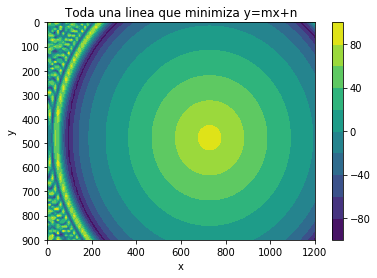

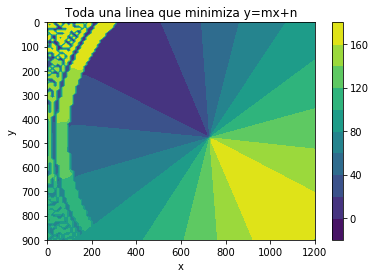

In [222]:
result_7 = (0.04952671,  0.00310034, -1.04782185,
             9.61696411e-02, -3.11311558e+00,  8.47643783e-03,  5.83185714e-04, 7.66455100e-03,
            -4.82552710e-03, -0.0022711518934522366,
            7.28125200e+02,  4.78181845e+02, 7.73853421e-01)
plot_altura(result_7)
plot_azimuth(result_7)

In [225]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

old_params = np.array([0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519])
new_params = np.array([9.61696411e-02, -3.11311558e+00,  8.47643783e-03,  5.83185714e-04, 7.66455100e-03])
(mega_alt_xi(old_params)/len(x_exp), mega_alt_xi(new_params)/len(x_exp))

(2.3206123914900973, 2.2365773977711614)

[subir](#index)<a id='section8'></a>
## 8) Buscamos C,A,F reduciendo altura con floats

In [238]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, E, ep, X0, Y0, a0 = ctes
        C, A, F, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), float(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, E, ep, X0, Y0, a0 = ctes
        C, A, F, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), float(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=2200)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]

In [239]:
init_params = [0.04952671,  0.00310034, -1.04782185]
ctes = [9.61696411e-02, -3.11311558e+00,  8.47643783e-03,  5.83185714e-04, 7.66455100e-03,
        -4.82552710e-03, -0.0022711518934522366,
         7.28125200e+02,  4.78181845e+02, 7.73853421e-01]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*init_params, *ctes), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []




























Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]


























Droping Outlayers:   1%|▌                                                        | 742/80771 [00:00<00:10, 7366.21it/s]


























Droping Outlayers:   2%|█                                                       | 1480/80771 [00:00<00:10, 7354.24it/s]


























Droping Outlayers:   3%|█▌                                                      | 2203/80771 [00:00<00:10, 7300.33it/s]


























Droping Outlayers:   4%|██                                                      | 2921/80771 [00:00<00:10, 7247.74it/s]


























Droping Outlayers:   4%|██▌                                                     | 3618/80771 [00:00<00:10, 7141.87it/s]


























Droping Outlayers:   5%|███                                                     | 4363/80771 [00:

Droping Outlayers:  50%|███████████████████████████▋                           | 40723/80771 [00:05<00:05, 7274.83it/s]


























Droping Outlayers:  51%|████████████████████████████▏                          | 41451/80771 [00:05<00:05, 7217.99it/s]


























Droping Outlayers:  52%|████████████████████████████▋                          | 42179/80771 [00:05<00:05, 7220.76it/s]


























Droping Outlayers:  53%|█████████████████████████████▏                         | 42902/80771 [00:06<00:05, 7186.31it/s]


























Droping Outlayers:  54%|█████████████████████████████▋                         | 43630/80771 [00:06<00:05, 7197.86it/s]


























Droping Outlayers:  55%|██████████████████████████████▏                        | 44350/80771 [00:06<00:05, 7161.96it/s]


























Droping Outlayers:  56%|██████████████████████████████▋                        | 45070/80771 [00:06<00:04, 7157.78it/s]






In [240]:
pbar = tqdm(total=2200, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]





























Aproximando altura y azimuth:   0%|                                                           | 0/2200 [00:00<?, ?it/s]



























Aproximando altura y azimuth:   0%|                                                 | 1/2200 [00:04<3:02:50,  4.99s/it]



























Aproximando altura y azimuth:   0%|                                                 | 2/2200 [00:09<3:02:12,  4.97s/it]


























Droping Outlayers: 100%|███████████████████████████████████████████████████████| 80771/80771 [00:24<00:00, 6905.43it/s]



























Aproximando altura y azimuth:   0%|                                                 | 3/2200 [00:14<3:00:54,  4.94s/it]



























Aproximando altura y azimuth:   0%|                                                 | 4/2200 [00:19<3:03:33,  5.02s/it]



























Aproximando altura y azimuth:   0%|                                                 | 5/220

Aproximando altura y azimuth:   2%|█▏                                              | 54/2200 [04:23<2:52:48,  4.83s/it]



























Aproximando altura y azimuth:   2%|█▏                                              | 55/2200 [04:28<2:51:30,  4.80s/it]



























Aproximando altura y azimuth:   3%|█▏                                              | 56/2200 [04:33<2:50:22,  4.77s/it]



























Aproximando altura y azimuth:   3%|█▏                                              | 57/2200 [04:38<2:51:02,  4.79s/it]



























Aproximando altura y azimuth:   3%|█▎                                              | 58/2200 [04:42<2:50:28,  4.78s/it]



























Aproximando altura y azimuth:   3%|█▎                                              | 59/2200 [04:47<2:49:53,  4.76s/it]



























Aproximando altura y azimuth:   3%|█▎                                              | 60/2200 [04:52<2:50:28,  4.78s/it

Aproximando altura y azimuth:   5%|██▎                                            | 109/2200 [08:46<2:44:49,  4.73s/it]



























Aproximando altura y azimuth:   5%|██▎                                            | 110/2200 [08:51<2:45:29,  4.75s/it]



























Aproximando altura y azimuth:   5%|██▎                                            | 111/2200 [08:56<2:44:57,  4.74s/it]



























Aproximando altura y azimuth:   5%|██▍                                            | 112/2200 [09:01<2:44:26,  4.73s/it]



























Aproximando altura y azimuth:   5%|██▍                                            | 113/2200 [09:05<2:44:51,  4.74s/it]



























Aproximando altura y azimuth:   5%|██▍                                            | 114/2200 [09:10<2:45:04,  4.75s/it]



























Aproximando altura y azimuth:   5%|██▍                                            | 115/2200 [09:15<2:45:24,  4.76s/it

Optimization terminated successfully.
         Current function value: 30198.420305
         Iterations: 90
         Function evaluations: 162


Aproximando altura y azimuth:   7%|███▍                                           | 162/2200 [13:04<2:44:28,  4.84s/it]


array([ 0.04933449,  0.00478405, -0.1298804 ])

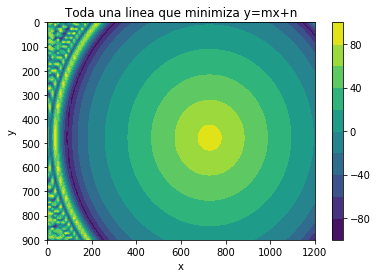

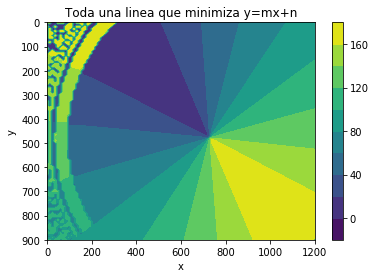

In [241]:
result_8 = (0.04933449,  0.00478405, -0.1298804,
             9.61696411e-02, -3.11311558e+00,  8.47643783e-03,  5.83185714e-04, 7.66455100e-03,
            -4.82552710e-03, -0.0022711518934522366,
            7.28125200e+02,  4.78181845e+02, 7.73853421e-01)
plot_altura(result_8)
plot_azimuth(result_8)

In [243]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

old_params = np.array([0.04952671,  0.00310034, -1.04782185])
new_params = np.array([0.04933449,  0.00478405, -0.1298804])
(mega_az_xi(old_params)/len(x_exp), mega_az_xi(new_params)/len(x_exp))

(15.901385581487377, 15.8990467723668)

[subir](#index)<a id='section9'></a>
## 9) Buscamos V,S,D,P,Q reduciendo altura con floats

In [247]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, E, ep, X0, Y0, a0 = ctes
        V, S, D, P, Q, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), float(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, E, ep, X0, Y0, a0 = ctes
        V, S, D, P, Q, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), float(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]

In [248]:
init_params = [9.61696411e-02, -3.11311558e+00,  8.47643783e-03,  5.83185714e-04, 7.66455100e-03]
ctes = [0.04933449,  0.00478405, -0.1298804,
        -4.82552710e-03, -0.0022711518934522366,
          7.28125200e+02,  4.78181845e+02, 7.73853421e-01]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:3],*init_params, *ctes[3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []
































Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]






























Droping Outlayers:   1%|▍                                                        | 702/80771 [00:00<00:11, 7016.36it/s]






























Droping Outlayers:   2%|▉                                                       | 1439/80771 [00:00<00:11, 7103.80it/s]






























Droping Outlayers:   3%|█▌                                                      | 2193/80771 [00:00<00:10, 7190.50it/s]






























Droping Outlayers:   4%|██                                                      | 2931/80771 [00:00<00:10, 7231.68it/s]






























Droping Outlayers:   5%|██▌                                                     | 3693/80771 [00:00<00:10, 7263.62it/s]






























Droping Outlayers:   5%|███                                          

Droping Outlayers:  49%|███████████████████████████▏                           | 39924/80771 [00:05<00:05, 7166.40it/s]






























Droping Outlayers:  50%|███████████████████████████▋                           | 40644/80771 [00:05<00:05, 7149.43it/s]






























Droping Outlayers:  51%|████████████████████████████▏                          | 41395/80771 [00:05<00:05, 7193.98it/s]






























Droping Outlayers:  52%|████████████████████████████▋                          | 42150/80771 [00:05<00:05, 7232.04it/s]






























Droping Outlayers:  53%|█████████████████████████████▏                         | 42896/80771 [00:05<00:05, 7282.62it/s]






























Droping Outlayers:  54%|█████████████████████████████▋                         | 43651/80771 [00:06<00:05, 7296.72it/s]






























Droping Outlayers:  55%|██████████████████████████████▏                        | 44381/80771 [00:06<

Droping Outlayers:  99%|██████████████████████████████████████████████████████▍| 79968/80771 [00:11<00:00, 7087.44it/s]






























Droping Outlayers: 100%|██████████████████████████████████████████████████████▉| 80678/80771 [00:11<00:00, 6925.85it/s]

In [249]:
pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

































Aproximando altura y azimuth:   0%|                                                           | 0/1100 [00:00<?, ?it/s]































Aproximando altura y azimuth:   0%|                                                 | 1/1100 [00:04<1:20:05,  4.37s/it]































Aproximando altura y azimuth:   0%|                                                 | 2/1100 [00:08<1:18:13,  4.27s/it]






























Droping Outlayers: 100%|███████████████████████████████████████████████████████| 80771/80771 [00:23<00:00, 6925.85it/s]































Aproximando altura y azimuth:   0%|▏                                                | 3/1100 [00:12<1:17:00,  4.21s/it]































Aproximando altura y azimuth:   0%|▏                                                | 4/1100 [00:16<1:17:50,  4.26s/it]































Aproximando altura y azimuth:   0%|▏                           

Aproximando altura y azimuth:   5%|██▎                                             | 53/1100 [03:28<1:07:42,  3.88s/it]































Aproximando altura y azimuth:   5%|██▎                                             | 54/1100 [03:32<1:07:31,  3.87s/it]































Aproximando altura y azimuth:   5%|██▍                                             | 55/1100 [03:37<1:10:00,  4.02s/it]































Aproximando altura y azimuth:   5%|██▍                                             | 56/1100 [03:40<1:09:08,  3.97s/it]































Aproximando altura y azimuth:   5%|██▍                                             | 57/1100 [03:44<1:08:26,  3.94s/it]































Aproximando altura y azimuth:   5%|██▌                                             | 58/1100 [03:48<1:09:17,  3.99s/it]































Aproximando altura y azimuth:   5%|██▌                                             | 59/1100 [

Aproximando altura y azimuth:  10%|████▌                                          | 107/1100 [06:59<1:04:04,  3.87s/it]































Aproximando altura y azimuth:  10%|████▌                                          | 108/1100 [07:03<1:04:44,  3.92s/it]































Aproximando altura y azimuth:  10%|████▋                                          | 109/1100 [07:07<1:04:25,  3.90s/it]































Aproximando altura y azimuth:  10%|████▋                                          | 110/1100 [07:11<1:05:49,  3.99s/it]































Aproximando altura y azimuth:  10%|████▋                                          | 111/1100 [07:15<1:05:10,  3.95s/it]































Aproximando altura y azimuth:  10%|████▊                                          | 112/1100 [07:19<1:04:36,  3.92s/it]































Aproximando altura y azimuth:  10%|████▊                                          | 113/1100 [

Aproximando altura y azimuth:  15%|██████▉                                        | 161/1100 [10:30<1:00:41,  3.88s/it]































Aproximando altura y azimuth:  15%|██████▉                                        | 162/1100 [10:34<1:00:41,  3.88s/it]































Aproximando altura y azimuth:  15%|██████▉                                        | 163/1100 [10:38<1:01:14,  3.92s/it]































Aproximando altura y azimuth:  15%|███████                                        | 164/1100 [10:42<1:01:15,  3.93s/it]































Aproximando altura y azimuth:  15%|███████                                        | 165/1100 [10:46<1:01:07,  3.92s/it]































Aproximando altura y azimuth:  15%|███████                                        | 166/1100 [10:50<1:01:38,  3.96s/it]































Aproximando altura y azimuth:  15%|███████▏                                       | 167/1100 [

Aproximando altura y azimuth:  20%|█████████▌                                       | 215/1100 [14:03<58:07,  3.94s/it]































Aproximando altura y azimuth:  20%|█████████▌                                       | 216/1100 [14:07<57:43,  3.92s/it]































Aproximando altura y azimuth:  20%|█████████▋                                       | 217/1100 [14:11<57:36,  3.91s/it]































Aproximando altura y azimuth:  20%|█████████▋                                       | 218/1100 [14:15<57:25,  3.91s/it]































Aproximando altura y azimuth:  20%|█████████▊                                       | 219/1100 [14:18<57:12,  3.90s/it]































Aproximando altura y azimuth:  20%|█████████▊                                       | 220/1100 [14:22<57:05,  3.89s/it]































Aproximando altura y azimuth:  20%|█████████▊                                       | 221/1100

Aproximando altura y azimuth:  24%|███████████▉                                     | 269/1100 [17:35<55:08,  3.98s/it]































Aproximando altura y azimuth:  25%|████████████                                     | 270/1100 [17:39<56:16,  4.07s/it]































Aproximando altura y azimuth:  25%|████████████                                     | 271/1100 [17:43<55:23,  4.01s/it]































Aproximando altura y azimuth:  25%|████████████                                     | 272/1100 [17:47<54:46,  3.97s/it]































Aproximando altura y azimuth:  25%|████████████▏                                    | 273/1100 [17:51<54:14,  3.94s/it]































Aproximando altura y azimuth:  25%|████████████▏                                    | 274/1100 [17:54<53:57,  3.92s/it]































Aproximando altura y azimuth:  25%|████████████▎                                    | 275/1100

Aproximando altura y azimuth:  29%|██████████████▍                                  | 323/1100 [21:06<50:21,  3.89s/it]































Aproximando altura y azimuth:  29%|██████████████▍                                  | 324/1100 [21:10<50:10,  3.88s/it]































Aproximando altura y azimuth:  30%|██████████████▍                                  | 325/1100 [21:14<50:08,  3.88s/it]































Aproximando altura y azimuth:  30%|██████████████▌                                  | 326/1100 [21:18<50:07,  3.89s/it]































Aproximando altura y azimuth:  30%|██████████████▌                                  | 327/1100 [21:22<50:05,  3.89s/it]































Aproximando altura y azimuth:  30%|██████████████▌                                  | 328/1100 [21:26<50:09,  3.90s/it]































Aproximando altura y azimuth:  30%|██████████████▋                                  | 329/1100

Optimization terminated successfully.
         Current function value: 29266.599810
         Iterations: 197
         Function evaluations: 336


Aproximando altura y azimuth:  31%|██████████████▉                                  | 336/1100 [21:57<49:56,  3.92s/it]


array([ 9.44302225e-02, -3.90770908e+00,  6.47675936e-03,  1.99616127e-03,
        5.31560995e-03])

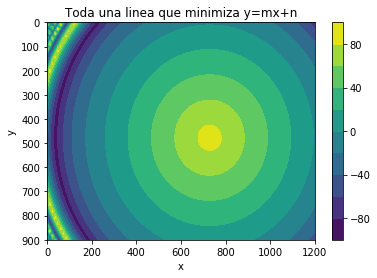

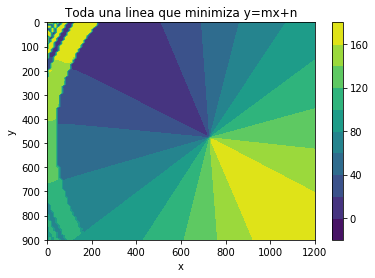

In [250]:
result_9 = (0.04933449,  0.00478405, -0.1298804,
             9.44302225e-02, -3.90770908e+00,  6.47675936e-03,  1.99616127e-03, 5.31560995e-03,
            -4.82552710e-03, -0.0022711518934522366,
            7.28125200e+02,  4.78181845e+02, 7.73853421e-01)
plot_altura(result_9)
plot_azimuth(result_9)

In [252]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

old_params = np.array([9.61696411e-02, -3.11311558e+00,  8.47643783e-03,  5.83185714e-04, 7.66455100e-03])
new_params = np.array([9.44302225e-02, -3.90770908e+00,  6.47675936e-03,  1.99616127e-03, 5.31560995e-03])
(mega_az_xi(old_params)/len(x_exp), mega_az_xi(new_params)/len(x_exp))

(15.8990467723668, 15.898487027535763)

[subir](#index)<a id='greedy'></a>
## Greedy
Buscamos C,A,F,V,S,D,P,Q,E,ep reduciendo altura y azimut con nuevo Xi (desde el resultado 6)

In [253]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_az_xi(x_list, y_list, alt_list, az_list, ctes = None):
    def acumulate_xi(params):
        X0, Y0, a0 = ctes
        C, A, F, V, S, D, P, Q, E, ep, = params
        suma_xi = 0
        for x, y, alt, az in zip(x_list, y_list, alt_list, az_list):
            alt_xi = construct_alt_xi(int(x), int(y), int(alt))
            az_xi = construct_az_xi(int(x), int(y), int(az))
            suma_xi += alt_xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
            suma_xi += az_xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        X0, Y0, a0 = ctes
        C, A, F, V, S, D, P, Q, E, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        X0, Y0, a0 = ctes
        C, A, F, V, S, D, P, Q, E, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_az_xi):
    new_params = optimize.fmin(mega_alt_az_xi, params, maxfun=2200)
    return [new_params]

In [254]:
init_params = [0.04952671,  0.00310034, -1.04782185,
                 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
                 -0.00415889519, -4.82552710e-03, -0.0022711518934522366]
ctes = [7.28125200e+02,  4.78181845e+02, 7.73853421e-01]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*init_params, *ctes), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_az_xi = construct_acumulate_alt_az_xi(x_exp, y_exp, alt_catalogo, az_catalogo, ctes)
results_list = []

































Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]































Droping Outlayers:   1%|▌                                                        | 764/80771 [00:00<00:10, 7483.78it/s]































Droping Outlayers:   2%|█                                                       | 1520/80771 [00:00<00:10, 7495.76it/s]































Droping Outlayers:   3%|█▌                                                      | 2259/80771 [00:00<00:10, 7460.79it/s]































Droping Outlayers:   4%|██                                                      | 2982/80771 [00:00<00:10, 7374.14it/s]































Droping Outlayers:   5%|██▌                                                     | 3721/80771 [00:00<00:10, 7362.77it/s]































Droping Outlayers:   6%|███                                   

Droping Outlayers:  50%|███████████████████████████▎                           | 40134/80771 [00:05<00:05, 7426.69it/s]































Droping Outlayers:  51%|███████████████████████████▊                           | 40877/80771 [00:05<00:05, 7275.42it/s]































Droping Outlayers:  52%|████████████████████████████▎                          | 41618/80771 [00:05<00:05, 7295.13it/s]































Droping Outlayers:  52%|████████████████████████████▊                          | 42355/80771 [00:05<00:05, 7295.31it/s]































Droping Outlayers:  53%|█████████████████████████████▎                         | 43097/80771 [00:05<00:05, 7315.49it/s]































Droping Outlayers:  54%|█████████████████████████████▊                         | 43829/80771 [00:05<00:05, 7257.56it/s]































Droping Outlayers:  55%|██████████████████████████████▎                        | 44556/80771 [

Droping Outlayers:  99%|██████████████████████████████████████████████████████▍| 79907/80771 [00:10<00:00, 7363.74it/s]































Droping Outlayers: 100%|██████████████████████████████████████████████████████▉| 80670/80771 [00:11<00:00, 7424.16it/s]































Droping Outlayers: 100%|███████████████████████████████████████████████████████| 80771/80771 [00:23<00:00, 7424.16it/s]

In [ ]:
pbar = tqdm(total=2200, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_az_xi)
pbar.close()
results_list[-1]

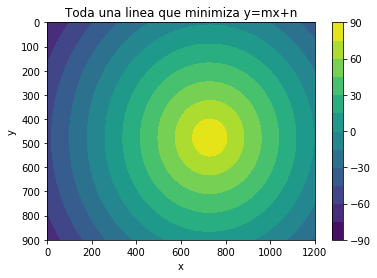

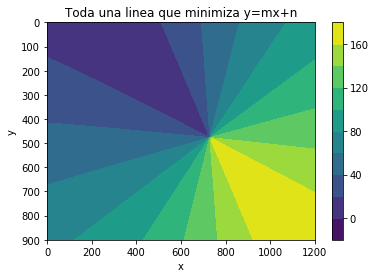

In [255]:
result_greedy = (0.04112766,  0.00561308, -0.94623894,  0.07209727, -0.77408275,
       -0.01452004,  0.00156322, -0.00570063, -0.00463522, -0.00562647, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01)
plot_altura(result_greedy)
plot_azimuth(result_greedy)

In [256]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

old_params = np.array([0.04952671,  0.00310034, -1.04782185,
                 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
                 -0.00415889519, -4.82552710e-03, -0.0022711518934522366])
new_params = np.array([0.04112766,  0.00561308, -0.94623894,  0.07209727, -0.77408275,
       -0.01452004,  0.00156322, -0.00570063, -0.00463522, -0.00562647])
(mega_alt_az_xi(old_params)/len(x_exp), mega_alt_az_xi(new_params)/len(x_exp))

(15.496449583554899, 15.438745297131694)

In [257]:
(mega_alt_xi(old_params)/len(x_exp), mega_alt_xi(new_params)/len(x_exp))

(2.3206123914900973, 2.2436382538941295)

In [258]:
(mega_az_xi(old_params)/len(x_exp), mega_az_xi(new_params)/len(x_exp))

(15.754315909701617, 15.747536192689807)

# Desarrollo

In [206]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))

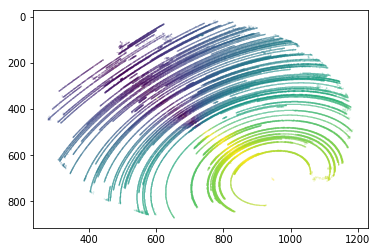

In [207]:
plt.gca().invert_yaxis()
plt.scatter(x_exp, y_exp, c=az_catalogo, s=0.01)

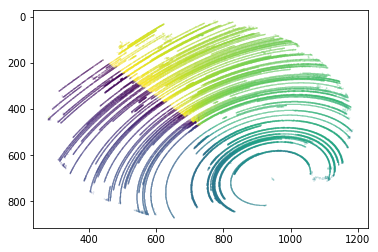

In [212]:
def azimut_corrector(data):
    x_center = 728
    for x in range(150, x_center):
        col_data = data.query("x=={}".format(x))
        if len(col_data):
            y_min = col_data.at[col_data.idxmin().az, "y"]
            for indx in col_data.query("y<{}".format(y_min)).index:
                data.at[indx, "az"] = 360 - col_data.at[indx, "az"]
    for x in range(x_center, 1201):
        col_data = data.query("x=={}".format(x))
        if len(col_data):
            y_min = col_data.at[np.abs(col_data.az - 180).idxmin(), "y"]
            for indx in col_data.query("y<{}".format(y_min)).index:
                data.at[indx, "az"] = 360 - col_data.at[indx, "az"]
    return data
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data["az"] = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values)))) 

data = azimut_corrector(data)

x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = data.az.values   
plt.gca().invert_yaxis()
plt.scatter(x_exp, y_exp, c=az_catalogo, s=0.01)

In [40]:
"""
Esto lo definimos por cada intento segun los parametros constantes que
queramos dejar
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
#         pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
#         pbar.update()
        return suma_xi
    return acumulate_xi

In [41]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = data.az.values
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo)

# plt.gca().invert_yaxis()
# plt.scatter(x_exp, y_exp, c=alt_catalogo, s=0.01)

In [43]:
(mega_alt_xi([0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, 0.08741648813678929, -0.0022711518934522366, 724.59618727, 472.68750979,np.pi/4])/len(x_exp),
mega_alt_xi([0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, 0.08741648813678929, -0.0022711518934522366, 724.59618727, 472.68750979, 0.82635545])/len(x_exp))

(2.2197296149958756, 2.22855601896949)

In [20]:
np.deg2rad(90)

1.5707963267948966

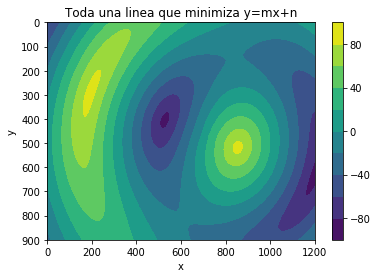

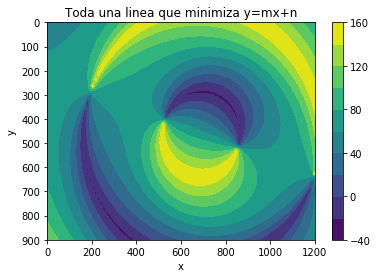

In [59]:
"""Esto pasa al mover ep"""